In [51]:
from pyscf import scf,gto
import numpy as np
import inspect
from FcMole import FcM
import matplotlib.pyplot as plt
from pyscf.geomopt.berny_solver import optimize
PTR_COORD=gto.mole.PTR_COORD

angstrom = 1 / 0.52917721067
from pyscf.grad import rhf as grhf  #### very important
from pyscf.hessian import rhf as hrhf # without those two mf.Gradients() and mf.Hessian() don't work
def DeltaV(mol,dL):
    mol.set_rinv_orig_(mol.atom_coords()[0])
    dV=mol.intor('int1e_rinv')*dL[0]
    mol.set_rinv_orig_(mol.atom_coords()[1])
    dV+=mol.intor('int1e_rinv')*dL[1]
    return -dV

In [5]:
dlfd=.01

In [6]:
#mol0=gto.M(atom="C 0 0 0; O 0 0 2.08436",unit="Bohr",basis="6-31G")
#mf0=scf.RHF(mol0)
#mf0.scf()
#optimize(mf0)

In [7]:
co_min=(1.116831+0.013835)*angstrom

In [143]:
mol0=gto.M(atom="C 0 0 0; O 0 0 {}".format(co_min),unit="Bohr",basis="6-31G")
mf0=scf.RHF(mol0)
mf0.scf()

converged SCF energy = -112.667221942958


-112.66722194295751

In [9]:
gradients=[]
hessians=[]

In [10]:
g0=mf0.Gradients()
gradients.append(g0.kernel())
h0=mf0.Hessian()
hessians.append(h0.kernel())

--------------- RHF gradients ---------------
         x                y                z
0 C    -0.0000000000     0.0000000000     0.0000143783
1 O     0.0000000000    -0.0000000000    -0.0000143783
----------------------------------------------


/home/giorgiod/miniconda3/lib/python3.7/site-packages/pyscf/lib/chkfile.py:71: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return val.value


In [11]:
def fdp(dL):
    mol1=FcM(fcs=[dL,-dL],atom="C 0 0 0; O 0 0 {}".format(co_min),unit="Bohr",basis="6-31G")
    mf1=scf.RHF(mol1)
    mf1.scf(dm0=mf1.init_guess_by_atom())
    g1=mf1.Gradients()
    grad=g1.grad()
    h1=mf1.Hessian()
    hess=h1.kernel()
    return(grad,hess)

In [12]:
for dL in [-2*dlfd,-dlfd,dlfd,2*dlfd]:
    grad,hess=fdp(dL)
    gradients.append(grad)
    hessians.append(hess)

converged SCF energy = -112.820177240134
--------------- RHF gradients ---------------
         x                y                z
0 C     0.0000000000    -0.0000000000     0.0037228753
1 O    -0.0000000000     0.0000000000    -0.0037228753
----------------------------------------------
converged SCF energy = -112.7435111227
--------------- RHF gradients ---------------
         x                y                z
0 C     0.0000000000     0.0000000000     0.0018623501
1 O    -0.0000000000    -0.0000000000    -0.0018623501
----------------------------------------------
converged SCF energy = -112.591309798024
--------------- RHF gradients ---------------
         x                y                z
0 C     0.0000000000    -0.0000000000    -0.0018209623
1 O    -0.0000000000     0.0000000000     0.0018209623
----------------------------------------------
converged SCF energy = -112.515774791297
--------------- RHF gradients ---------------
         x                y                z
0 C

In [56]:
#targets
mol_nn=FcM(fcs=[1,-1],atom="C 0 0 0; O 0 0 {}".format(co_min),unit="Bohr",basis="6-31G")
mf_nn=scf.RHF(mol_nn)
mf_nn.scf(dm0=mf_nn.init_guess_by_atom())
g_nn=mf_nn.Gradients()
grad_nn=g_nn.grad()
h_nn=mf_nn.Hessian()
hess_nn=h_nn.kernel()
#targets
mol_bf=FcM(fcs=[-1,1],atom="C 0 0 0; O 0 0  {}".format(co_min),unit="Bohr",basis="6-31G")
mf_bf=scf.RHF(mol_bf)
mf_bf.scf(dm0=mf_bf.init_guess_by_atom())
g_bf=mf_bf.Gradients()
grad_bf=g_bf.grad()
h_bf=mf_bf.Hessian()
hess_bf=h_bf.kernel()

converged SCF energy = -106.983582668535
--------------- RHF gradients ---------------
         x                y                z
0 C    -0.0000000000     0.0000000000    -0.1009626290
1 O     0.0000000000    -0.0000000000     0.1009626290
----------------------------------------------
converged SCF energy = -122.180160017684
--------------- RHF gradients ---------------
         x                y                z
0 C    -0.0000000000    -0.0000000000     0.2267143222
1 O     0.0000000000     0.0000000000    -0.2267143222
----------------------------------------------


In [14]:
gradients_a=np.asarray(gradients)
hessians_a=np.asarray(hessians)

In [15]:
hessians_a.shape

(5, 2, 2, 3, 3)

In [16]:
#approximating gradients and hessians for NN
deriv_g1=np.zeros((2,3))
deriv_g2=np.zeros((2,3))
deriv_g3=np.zeros((2,3))
deriv_g4=np.zeros((2,3))
deriv_h1=np.zeros((2, 2, 3, 3))
deriv_h2=np.zeros((2, 2, 3, 3))
deriv_h3=np.zeros((2, 2, 3, 3))
deriv_h4=np.zeros((2, 2, 3, 3))

for i in range(5):
    deriv_g1+=gradients_a[i,...]*np.array([0,1/12,-2/3,2/3,-1/12])[i]/dlfd
    deriv_g2+=gradients_a[i,...]*np.array([-5/2,-1/12,4/3,4/3,-1/12])[i]/dlfd**2#  −1/12	4/3	−5/2	4/3	−1/12
    deriv_g3+=gradients_a[i,...]*np.array([0,-1/2,1,-1,1/2])[i]/dlfd**3#    −1/2	 1	0	−1	1/2
    deriv_g4+=gradients_a[i,...]*np.array([6,1,-4,-4,1])[i]/dlfd**4#  1	−4	6	−4	1
    #electronic gradients 

    #hessians 
    deriv_h1+=hessians_a[i,...]*np.array([0,1/12,-2/3,2/3,-1/12])[i]/dlfd
    deriv_h2+=hessians_a[i,...]*np.array([-5/2,-1/12,4/3,4/3,-1/12])[i]/dlfd**2#  −1/12	4/3	−5/2	4/3	−1/12
    deriv_h3+=hessians_a[i,...]*np.array([0,-1/2,1,-1,1/2])[i]/dlfd**3#    −1/2	 1	0	−1	1/2
    deriv_h4+=hessians_a[i,...]*np.array([6,1,-4,-4,1])[i]/dlfd**4#  1	−4	6	−4	1

In [17]:
derivs_gs=np.asarray([deriv_g1,deriv_g2,deriv_g3,deriv_g4])
derivs_h=np.asarray([deriv_h1,deriv_h2,deriv_h3,deriv_h4])

In [18]:
derivs_h[0][1,1,2,2],derivs_h[0][1,0,2,2]

(-0.001094814882423023, 0.0010948145924469799)

In [19]:
pred_nn=np.zeros((2,3))
pred_bf=np.zeros((2,3))
g_vl_nn=[]
g_vl_bf=[]
pred_nn=np.einsum('xij,x->ij',derivs_gs,np.asarray([1,0,0, 0]))+gradients[0]
pred_bf=np.einsum('xij,x->ij',derivs_gs,np.asarray([-1,0,0,0]))+gradients[0]
g_vl_nn.append(pred_nn[1,2]),g_vl_bf.append(pred_bf[1,2])
pred_nn=np.einsum('xij,x->ij',derivs_gs,np.asarray([1,.5,0, 0]))+gradients[0]
pred_bf=np.einsum('xij,x->ij',derivs_gs,np.asarray([-1,-.5,0,0]))+gradients[0]
g_vl_nn.append(pred_nn[1,2]),g_vl_bf.append(pred_bf[1,2])
pred_nn=np.einsum('xij,x->ij',derivs_gs,np.asarray([1,0.5,1/6, 0]))+gradients[0]
pred_bf=np.einsum('xij,x->ij',derivs_gs,np.asarray([-1,0.5,-1/6,0]))+gradients[0]
g_vl_nn.append(pred_nn[1,2]),g_vl_bf.append(pred_bf[1,2])

(None, None)

In [20]:
g_vl_nn

[0.1841535029403746, 0.12104615942504063, 0.09841323218893312]

In [21]:
grad_nn,grad_bf

(array([[-1.55954735e-17,  3.15287198e-17, -1.00962629e-01],
        [ 1.55954735e-17, -3.15287198e-17,  1.00962629e-01]]),
 array([[-5.56531651e-16, -1.32646127e-16,  2.26714322e-01],
        [ 5.56531651e-16,  1.32646127e-16, -2.26714322e-01]]))

In [22]:
pred_hess_nn=np.zeros((2,2,3,3))
pred_hess_bf=np.zeros((2,2,3,3))
h_vl_nn=[]
h_vl_bf=[]
pred_hess_nn=np.einsum('xijkl,x->ijkl',derivs_h,np.asarray([1,0,0, 0]))+hessians[0]
pred_hess_bf=np.einsum('xijkl,x->ijkl',derivs_h,np.asarray([-1,0,0,0]))+hessians[0]
h_vl_nn.append(pred_hess_nn[0,0,2,2]),h_vl_bf.append(pred_hess_bf[0,0,2,2])
pred_hess_nn=np.einsum('xijkl,x->ijkl',derivs_h,np.asarray([1,0.5,0,0]))+hessians[0]
pred_hess_bf=np.einsum('xijkl,x->ijkl',derivs_h,np.asarray([-1,0.5,0,0]))+hessians[0]
h_vl_nn.append(pred_hess_nn[0,0,2,2]),h_vl_bf.append(pred_hess_bf[0,0,2,2])
pred_hess_nn=np.einsum('xijkl,x->ijkl',derivs_h,np.asarray([1,0.5,1/6, 0]))+hessians[0]
pred_hess_bf=np.einsum('xijkl,x->ijkl',derivs_h,np.asarray([-1,0.5,-1/6,0]))+hessians[0]
h_vl_nn.append(pred_hess_nn[0,0,2,2]),h_vl_bf.append(pred_hess_bf[0,0,2,2])

(None, None)

In [23]:
hess_nn[0,0,2,2],hess_bf[0,0,2,2]

(1.4701806810199773, 1.4895474965530386)

In [24]:
h_vl_nn,h_vl_bf

([1.3549274217680551, 1.4744721420962907, 1.4647614751593132],
 [1.3571170510447192, 1.4766617713729548, 1.4863724383099324])

In [25]:
import matplotlib.pyplot as plt

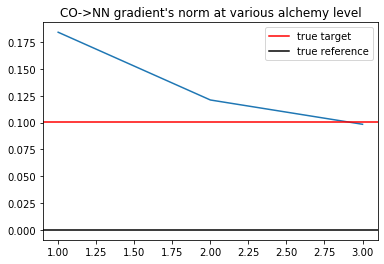

In [189]:
plt.plot([1,2,3],g_vl_nn)
plt.axhline(grad_nn[1,2],color="red",label="true target")
plt.axhline(gradients[0][1,2],color="black",label="true reference")
plt.legend()
plt.title("CO->NN gradient's norm at various alchemy level")
plt.savefig("grad_nn.png")

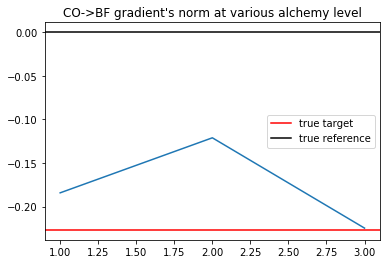

In [190]:
plt.plot([1,2,3],g_vl_bf)
plt.axhline(grad_bf[1,2],color="red",label="true target")
plt.axhline(gradients[0][1,2],color="black",label="true reference")
plt.legend()
plt.title("CO->BF gradient's norm at various alchemy level")
plt.savefig("grad_bf.png")

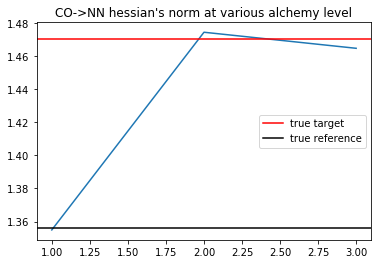

In [191]:
plt.plot([1,2,3],h_vl_nn)
plt.axhline(hess_nn[0,0,2,2],color="red",label="true target")
plt.axhline(hessians[0][0,0,2,2],color="black",label="true reference")
plt.legend()
plt.title("CO->NN hessian's norm at various alchemy level")
plt.savefig("hess_nn.png")

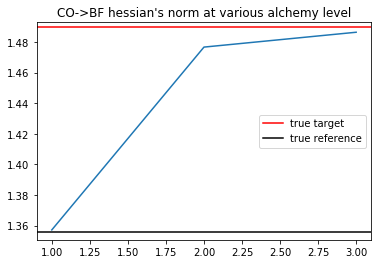

In [192]:
plt.plot([1,2,3],h_vl_bf)
plt.axhline(hess_bf[0,0,2,2],color="red",label="true target")
plt.axhline(hessians[0][0,0,2,2],color="black",label="true reference")
plt.legend()
plt.title("CO->BF hessian's norm at various alchemy level")
plt.savefig("hess_bf.png")

In [154]:
i=0
mol_nn=FcM(fcs=[1,-1],atom="C 0 0 0; O 0 0 {}".format(co_min),unit="Bohr",basis="6-31G")
mf_nn=scf.RHF(mol_nn)
mf_nn.scf(dm0=mf_nn.init_guess_by_atom())
g_nn=mf_nn.Gradients()
g=g_nn.grad()
h_nn=mf_nn.Hessian()
h=h_nn.kernel()
return_list=[]
r0=mf_nn.mol.atom_coord(1)[2]
print(r0)
while (np.linalg.norm(g)>1e-4) and i<10:
    mol_nn=FcM(fcs=[1,-1],atom="C 0 0 0; O 0 0 {}".format(r0-g[1,2]/h[1,1,2,2]),unit="Bohr",basis="6-31G")
    mf_nn=scf.RHF(mol_nn)
    mf_nn.scf(dm0=mf_nn.init_guess_by_atom())
    g_nn=mf_nn.Gradients()
    g=g_nn.grad()
    h_nn=mf_nn.Hessian()
    h=h_nn.kernel()
    print(r0,mf_nn.mol.atom_coords(),g[1,2],h[1,1,2,2])
    r0=mf_nn.mol.atom_coord(1)[2]    
    return_list.append([r0,g])
    i+=1

converged SCF energy = -106.983582668535
--------------- RHF gradients ---------------
         x                y                z
0 C    -0.0000000000     0.0000000000    -0.1009626290
1 O     0.0000000000    -0.0000000000     0.1009626290
----------------------------------------------
2.1366490793669004
converged SCF energy = -106.986738747751
--------------- RHF gradients ---------------
         x                y                z
0 C     0.0000000000    -0.0000000000     0.0138263351
1 O    -0.0000000000     0.0000000000    -0.0138263351
----------------------------------------------
2.1366490793669004 [[0.         0.         0.        ]
 [0.         0.         2.06797546]] -0.01382633508550235 1.8880621235678774
converged SCF energy = -106.986789813765
--------------- RHF gradients ---------------
         x                y                z
0 C     0.0000000000    -0.0000000000     0.0001801913
1 O    -0.0000000000     0.0000000000    -0.0001801913
-----------------------------

In [155]:
nn_min=2.07539647

In [156]:
i=0
mol_nn=FcM(fcs=[-1,1],atom="C 0 0 0; O 0 0 {}".format(co_min),unit="Bohr",basis="6-31G")
mf_nn=scf.RHF(mol_nn)
mf_nn.scf(dm0=mf_nn.init_guess_by_atom())
g_nn=mf_nn.Gradients()
g=g_nn.grad()
h_nn=mf_nn.Hessian()
h=h_nn.kernel()
return_list=[]
r0=mf_nn.mol.atom_coord(1)[2]
print(r0)
while (np.linalg.norm(g)>1e-4) and i<10:
    mol_nn=FcM(fcs=[-1,1],atom="C 0 0 0; O 0 0 {}".format(r0-g[1,2]/h[1,1,2,2]),unit="Bohr",basis="6-31G")
    mf_nn=scf.RHF(mol_nn)
    mf_nn.scf(dm0=mf_nn.init_guess_by_atom())
    g_nn=mf_nn.Gradients()
    g=g_nn.grad()
    h_nn=mf_nn.Hessian()
    h=h_nn.kernel()
    print(r0,mf_nn.mol.atom_coords(),g[1,2],h[1,1,2,2])
    r0=mf_nn.mol.atom_coord(1)[2]    
    return_list.append([r0,g])
    i+=1

converged SCF energy = -122.180160017684
--------------- RHF gradients ---------------
         x                y                z
0 C     0.0000000000     0.0000000000     0.2267143222
1 O    -0.0000000000    -0.0000000000    -0.2267143222
----------------------------------------------
2.1366490793669004
converged SCF energy = -122.200191817239
--------------- RHF gradients ---------------
         x                y                z
0 C    -0.0000000000    -0.0000000000     0.0527023597
1 O     0.0000000000     0.0000000000    -0.0527023597
----------------------------------------------
2.1366490793669004 [[0.         0.         0.        ]
 [0.         0.         2.28885257]] -0.05270235972569104 0.8488695937846931
converged SCF energy = -122.201951578903
--------------- RHF gradients ---------------
         x                y                z
0 C    -0.0000000000    -0.0000000000     0.0058808628
1 O     0.0000000000     0.0000000000    -0.0058808628
-----------------------------

In [157]:
bf_min=2.35993276

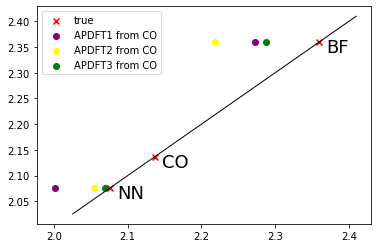

In [188]:
plt.plot([nn_min-.05,bf_min+.05],[nn_min-.05,bf_min+.05],color="black",lw=1)
plt.scatter([nn_min,co_min,bf_min],[nn_min,co_min,bf_min],marker="x",color="red",label="true")
plt.scatter(co_min-g_vl_nn[0]/h_vl_nn[0],nn_min,color="purple",label="APDFT1 from CO")
plt.scatter(co_min-g_vl_nn[1]/h_vl_nn[1],nn_min,color="yellow",label="APDFT2 from CO")
plt.scatter(co_min-g_vl_nn[2]/h_vl_nn[2],nn_min,color="green",label="APDFT3 from CO")
plt.scatter(co_min-g_vl_bf[0]/h_vl_bf[0],bf_min,color="purple")
plt.scatter(co_min-g_vl_bf[1]/h_vl_bf[1],bf_min,color="yellow")
plt.scatter(co_min-g_vl_bf[2]/h_vl_bf[2],bf_min,color="green")
plt.legend()
plt.text(co_min+.01,co_min-.02,"CO",size=18)
plt.text(nn_min+.01,nn_min-.02,"NN",size=18)
plt.text(bf_min+.01,bf_min-.02,"BF",size=18)
plt.savefig("CO_NN_BF.png")